# Wine Investing

# 0. Introduction

**TO DO**
- re-read all comments and code
- put data in a table and visualise, which is the best investment?

This notebook analyses the prices of various kinds of wine throughout time.We are interested in finding interesting investment opportunities.
To accomplish this we will analyse the risk and return on different types of wine. The most promising wines can than be combined to construct an efficient portfolio

This notebook is a condensed version of the full analysis done

In [82]:
#import libraries
import os
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import normaltest

In [83]:
#importing the datasets of four types of wine
red_path = os.path.abspath('Red.csv')
rose_path = os.path.abspath('Rose.csv')
sparkling_path = os.path.abspath('Sparkling.csv')
white_path = os.path.abspath('White.csv')

df_red = pd.read_csv(red_path, na_values=['N.V.'])
df_rose = pd.read_csv(rose_path, na_values=['N.V.'])
df_sparkling = pd.read_csv(sparkling_path, na_values=['N.V.'])
df_white = pd.read_csv(white_path, na_values=['N.V.'])

In [84]:
#setting the seaborn lay-out style
sns.set_theme(style='whitegrid')
palette = sns.color_palette('colorblind')
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 1.5,'dpi': 600})

# 1. Data exploration

## 1.1. The dataset

In [85]:
df_sparkling.isnull().sum()

Name                 0
Country              0
Region               0
Winery               0
Rating               0
NumberOfRatings      0
Price                0
Year               728
dtype: int64

In [86]:
df_red.shape

(8666, 8)

In [87]:
df_white.shape

(3764, 8)

In [88]:
df_sparkling.shape

(1007, 8)

In [89]:
df_rose.shape

(397, 8)

**Insights**
Red and white wine are the biggest categories,
sparkling and rose wine have less observations this is especially the case when we delete missing data.

some issues with the data
- sparkling wine has a lot of empty years, limiting our observations
- Country and winery have a lot of different categories, we cannot one-hot encode all of them.

In [90]:
# Identify each type to be able to distinguish them
df_red['type'] = 'red'
df_rose['type'] = 'rose'
df_sparkling['type'] = 'sparkling'
df_white['type'] = 'white'

In [91]:
# Create one dataset to compare the different types of wine
df = pd.concat([df_red, df_rose, df_sparkling, df_white], ignore_index=True )

In [92]:
df.tail()

,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year,type
13829,Sauvignon Blanc 2019,New Zealand,Marlborough,Oyster Bay,4.0,4423,10.66,2019.0,white
13830,Vinho Verde Sweet N.V.,Portugal,Vinho Verde,Casal Garcia,4.0,4609,5.05,NaN,white
13831,Sauvignon Blanc 2018,New Zealand,Marlborough,Kim Crawford,3.9,5105,14.90,2018.0,white
13832,Sauvignon Blanc 2019,New Zealand,Marlborough,Hans Greyl,4.2,5817,7.75,2019.0,white
13833,Vinho Verde Branco N.V.,Portugal,Vinho Verde,Casal Garcia,3.7,62980,4.35,NaN,white


## 1.2. LogPrice

In [93]:
# Logscaling price to make price closer to normal distribution
df['logprice']=np.log(df['Price'])

Text(0.5, 1.0, 'Density estimation for logprice')

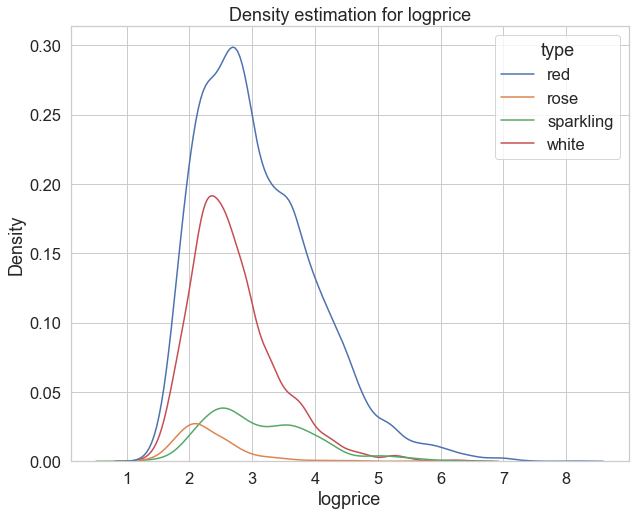

In [94]:
# Comparing the distribution of logprice of each wine type
plt.figure(figsize=(10,8))
sns.kdeplot(x=df['logprice'], hue=df['type'])
plt.title('Density estimation for logprice')

C:\Users\32474\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


Text(0.5, 1.0, 'QQ-plot of logprice against the normal distribution')

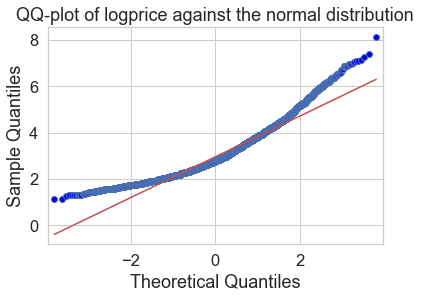

In [95]:
# Comparing the distribution of logprice against the normal distribution in a qq-plot
sm.qqplot(df['logprice'], line='s')
plt.title('QQ-plot of logprice against the normal distribution')

In [96]:
# statistically test for normality
normaltest(df['logprice'])

NormaltestResult(statistic=2122.7343182816126, pvalue=0.0)

**Insights**
We observe that logprice is non-normal distributed.
- The statistical test is significant, indicating the sample is not from a normal distribution
- The qq-plot indicates that mostly the tails deviate from the normal distribution
- The density plot indicates that very low prices are rare, but this amount increases steep. Most logprices are between 2 and 3, after that the frequency declines more steadily

## 1.3. Impact of variables on LogPrice

Text(0.5, 1.0, 'logprice per type of wine')

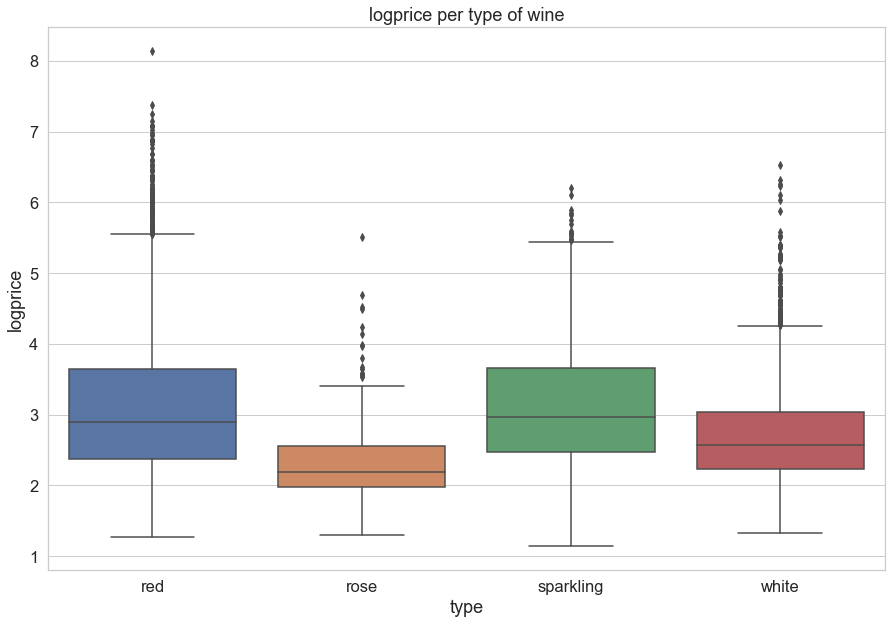

In [97]:
plt.figure(figsize=(15,10))
sns.boxplot(y=df['logprice'], x=df['type'])
plt.title('logprice per type of wine')

<AxesSubplot:xlabel='Year', ylabel='logprice'>

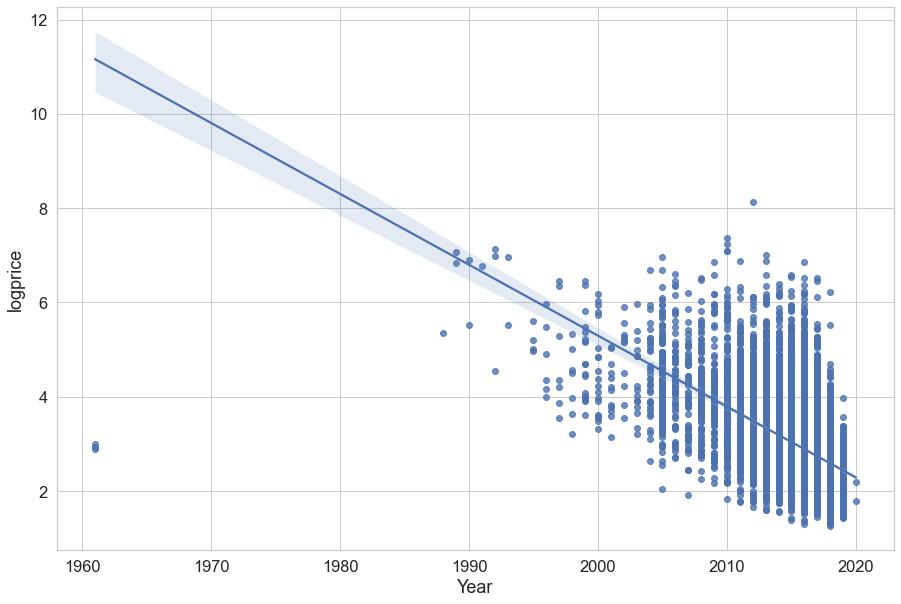

In [98]:
plt.figure(figsize=(15,10))
sns.regplot(data=df, x='Year', y='logprice' )

Text(0.5, 1.0, 'Boxplot for Logprice per Country')

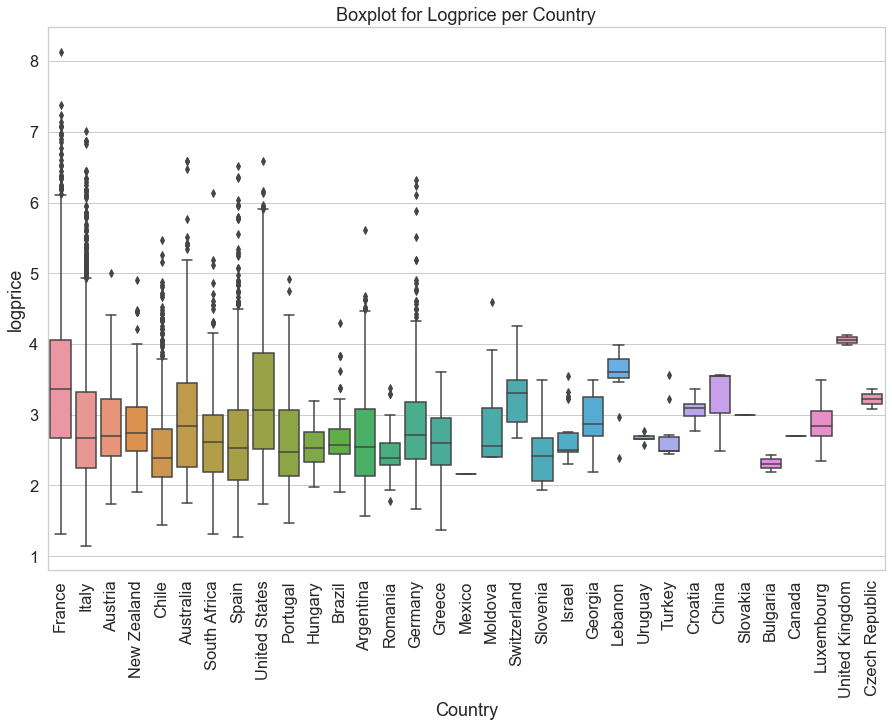

In [99]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
sns.boxplot(y=df['logprice'], x=df['Country'])
plt.title('Boxplot for Logprice per Country')

Text(0.5, 1.0, 'Scatterplot Logprice per rating')

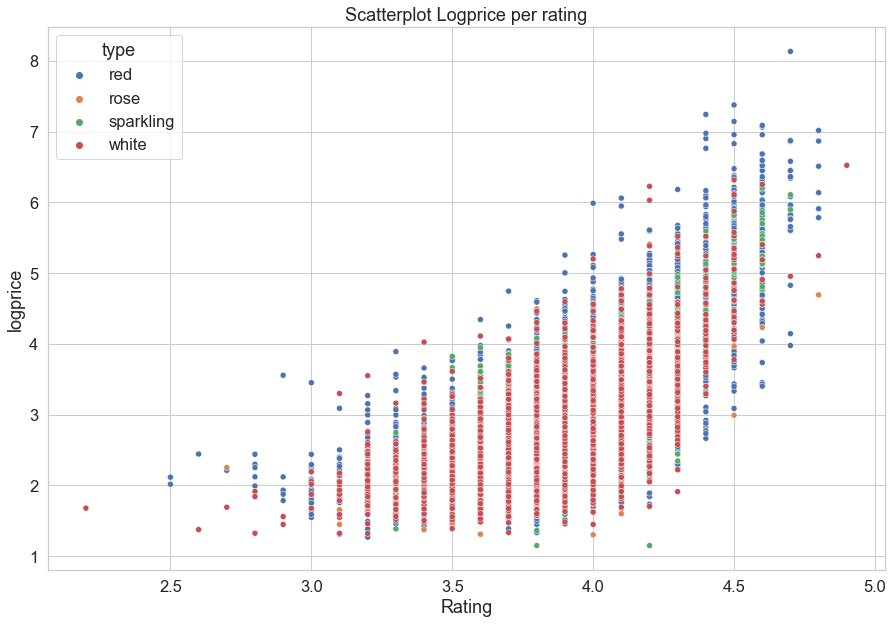

In [100]:
plt.figure(figsize=(15,10))
sns.scatterplot(y=df['logprice'], x=df['Rating'], hue = df['type'])
plt.title('Scatterplot Logprice per rating')

**Insights**
- sparkling is the most expensive on average, followed by red and white
- price tend to go down if the year of production increases, or in other words older wines are more expensive
- wine of different countries has different prices
- price tends to go up if the rating increases

# 2. Data analysis

## 2.1. Linear Regression

In this part we will use linear regression to analyse the impact of logprice throughout the years.
This will give us an indication how much we can expect to gain (or lose each year)

Note that the assumption of normal distribution is not met. However it is important for us to isolate the effect of time on the price.
This can be done with linear regression. We do have to take the exact numbers with a grain of salt.
Nevertheless, this method will give us a first idea of the investment possibilities of wine.

In [101]:
# Defining a regression function that fits an OLS and returns the coefficients and R-squared

def regression(x,y):
    """fit OLS-regression and return coefficients and r-squared"""
    x = sm.add_constant(x)
    est = sm.OLS(y, x).fit()
    coef = est.params
    rsquared = est.rsquared
    return(coef, rsquared)

In [102]:
# Because we work with a log scaled dependent variable we have to transform out coefficients to interpret them
def transform(log_coef):
    """Takes in a coefficient in terms of log-scaled variable,
     and returns a coefficient indicating the percentage change of the dependant variable per one-unit increase of independant variable"""
    percentage_coef = (math.exp(log_coef) - 1) * 100
    return percentage_coef

### Red wine

In [103]:
# Converting the year variable to the age of the wine, we set 2019 as year 0 since this is the youngest wine with sufficient data
df_red['year_old'] = 2019 - df_red['Year']
df_red['logprice'] = np.log(df_red['Price'])

In [104]:
# Simple linear regression price based on years old
# The years 2019 till 2005 (converted to years_old) are selected. These years have at least 30 observations each
df_red_reg = df_red.loc[df_red['year_old'] <= 14]
x_red = df_red_reg['year_old'].to_numpy().reshape((-1, 1))
y_red = df_red_reg['logprice'].to_numpy()

In [105]:
# Get regression coefficients
coef_red, r2_red = regression(x_red, y_red)

In [106]:
# Get the percentage change in price per year
transform(coef_red[1])

18.84360678048722

In [107]:
# R-squared can be used as a measure of risk, were a higher R-squared means a saver investment
r2_red

0.2674161594721013

In [108]:
# Store the results in a dataframe
# we take 1 - R-squared as the risk factor, if this measure increases less of the volatility is captured with the time variable
red_results = pd.DataFrame([[transform(coef_red[1]), 1 - r2_red]], columns=['return', 'risk'])
red_results.rename(index={0: 'red_wine'}, inplace=True)

### Rose wine

In [109]:
#converting year to year_old
df_rose['year_old'] = 2019 - df_rose['Year']
df_rose['logprice'] = np.log(df_rose['Price'])

In [110]:
# Simple linear regression price based on years old
# The years 2019 till 2017 are selected, these have at least 30 observations each
df_rose_reg = df_rose.loc[df_rose['year_old'] <= 2]
x_rose = df_rose_reg['year_old'].to_numpy().reshape((-1, 1))
y_rose = df_rose_reg['logprice'].to_numpy()

In [111]:
coef_rose, r2_rose = regression(x_rose,y_rose)

In [112]:
# Get the percentage change in price per year
transform(coef_rose[1])

10.366633257778402

In [113]:
# R-squared can be used as a measure of risk, were a higher R-squared means a saver investment
r2_rose

0.015590101080031116

In [114]:
# Store the results in a dataframe
# we take 1 - R-squared as the risk factor, if this measure increases less of the volatility is captured with the time variable
rose_results = pd.DataFrame([[transform(coef_rose[1]), 1 - r2_rose]], columns=['return', 'risk'])
rose_results.rename(index={0: 'rose_wine'}, inplace=True)

### Sparkling wine

In [115]:
# Converting year to year_old
df_sparkling['year_old'] = 2019 - df_sparkling['Year']
df_sparkling['logprice'] = np.log(df_sparkling['Price'])

In [116]:
# Simple linear regression, price based on years old
# The years 2019 till 2006 are selected, these have at least 10 observations
df_sparkling_reg = df_sparkling.loc[df_sparkling['year_old'] <= 13]
x_spark = df_sparkling_reg['year_old'].to_numpy().reshape((-1, 1))
y_spark = df_sparkling_reg['logprice'].to_numpy()

In [117]:
coef_spark, r2_spark = regression(x_spark, y_spark)

In [118]:
# Get the percentage change in price per year
transform(coef_spark[1])

21.19234648086794

In [119]:
# R-squared can be used as a measure of risk, were a higher R-squared means a saver investment
r2_spark

0.6875582411521389

In [120]:
# Store the results in a dataframe
# we take 1 - R-squared as the risk factor, if this measure increases less of the volatility is captured with the time variable
spark_results= pd.DataFrame([[transform(coef_spark[1]), 1 - r2_spark]], columns=['return', 'risk'])
spark_results.rename(index={0: 'sparkling_wine'}, inplace=True)

### White wine

In [121]:
#converting year to year_old
df_white['year_old'] = 2019 - df_white['Year']
df_white['logprice'] = np.log(df_white['Price'])

In [122]:
# Simple linear regression price based on years old
# The years 2019 till 2013 are selected, these have at least 30 observations each
df_white_reg = df_white.loc[(df_white['year_old'] <= 6) & (df_white['year_old'] >=0)]
x_white = df_white_reg['year_old'].to_numpy().reshape((-1, 1))
y_white = df_white_reg['logprice'].to_numpy()

In [123]:
coef_white, r2_white = regression(x_white, y_white)

In [124]:
# Get the percentage change in price per year
transform(coef_white[1])

29.35032302963996

In [125]:
# R-squared can be used as a measure of risk, were a higher R-squared means a saver investment
r2_white

0.2594479240327032

In [126]:
# Store the results in a dataframe
# we take 1 - R-squared as the risk factor, if this measure increases less of the volatility is captured with the time variable
white_results = pd.DataFrame([[transform(coef_white[1]), 1 - r2_white]], columns=['return', 'risk'])
white_results.rename(index={0: 'white_wine'}, inplace=True)

In [127]:
# Combine all results
results = pd.concat([red_results, rose_results, spark_results, white_results])
results

,return,risk
red_wine,18.843607,0.732584
rose_wine,10.366633,0.984410
sparkling_wine,21.192346,0.312442
white_wine,29.350323,0.740552


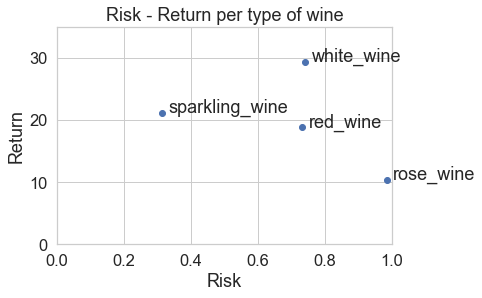

In [128]:
# plot the results of the regression - analysis
plt.scatter(results['risk'], results['return'])
plt.xlabel('Risk')
plt.ylabel('Return')
plt.title("Risk - Return per type of wine")
plt.xlim(0, 1)
plt.ylim(0, 35)
for idx, row in results.iterrows():
    plt.text(row['risk'] + 0.02, row['return'] + 0.02, idx)

**Insights**
- Overall the wines seem a high risk high reward investment
    - with returns around 20% - 30% for most wines
- Rose wine is a poor investment decision since it is very risky and has the lowest return

Modern portfolio theory states that assets can be combined to **reduce risk and get optimal returns**.
This will be tested by combining the white, red and sparkling wine in an **efficient portfolio**

## 2.2. Portfolio optimization

We need prices per year for every type of wine to calculate the optimal portfolio
We collected average yearly prices for the three most promising wines. This data was than used for portfolio optimization

In [129]:
# Retrieving the average price for red wine from 2019 till 2009
df_rr = df_red.groupby(['year_old'])['Price'].mean()
df_rr = df_rr.iloc[0:11].to_frame()
df_rr.columns = ['price_red']

In [130]:
# Retrieving the average price for white wine from 2019 till 2009
df_rw = df_white.groupby(['year_old'])['Price'].mean()
df_rw = df_rw.iloc[1:12].to_frame()
df_rw.columns = ['price_white']

In [131]:
# Retrieving the average price for sparkling wine from 2019 till 2009
df_rs = df_sparkling.groupby(['year_old'])['Price'].mean()
df_rs = df_rs.iloc[0:11].to_frame()
df_rs.columns = ['price_sparkling']

In [132]:
df_price = pd.concat([df_rr, df_rw, df_rs], axis=1)

In [133]:
# Low correlation is needed to create the diversification effect
df_price.corr()

,price_red,price_white,price_sparkling
price_red,1.000000,0.667913,0.793653
price_white,0.667913,1.000000,0.623134
price_sparkling,0.793653,0.623134,1.000000


There seems to be some diversification possibility since the correlations of the wine prices are not 1.
In particular the lower correlation for white wine with the other two types gives hope for improvements.

In [134]:
# Saving the dataset
df_price.to_csv('price_per_type.csv')

Further optimization is done in a other [notebook](https://github.com/SeppeHousen/wine-investment/blob/main/Wine_portfolio_optimizer.ipynb).
Due to dependencies I opted to do the analysis in the Google Colaboratory environment